# Voynich Language Analysis

## Brian Kitano

## Introduction
Via [this blog post](https://voynichattacks.wordpress.com/2017/09/26/using-t-distributed-stochastic-neighbor-embedding-tsne-to-cluster-folios/), it appears that the Voynich Manuscript (VMS) might be written in two separate languages. In this paper, we will test different approaches on disambiguating noisy transcriptions of two mixed languages which use the same alphabet.

## Testing
In order to test our methods, we need to have a known sample document to analyze. Thus, we need to generate documents that are noisy, bilingual (or more), and mixed around. In VMS, it appears that the languages are separated by folio, so we’ll do the same here. Consider if we mixed it on a word to word basis then the sentences would be meaningless, and if we mixed it on a sentence to sentence basis the paragraphs would be meaningless, but if VMS is mixed folio by folio, the document at a whole would appear interpretable but jumbled. We will test each tier of mixing.

We'll first create a test document, which in this case will be Moby Dick, by Herman Melville. 

## Previous Work

Essentially all previous work has asked a similar, but significantly different question: "what languages are present?" This contrasts because theirs are recognition based, meaning they require both an assumption of what languages are present, and a corpus to train on. If they don't know what language is present, then their models don't work. However, I intend to exploit similar methods in order to determine the count present. In other words, all previous work is based on supervised training, whereas mine is (must be) based on unsupervised learning methods.

[statistical identification of language](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.48.1958&rep=rep1&type=pdf)

[natural language identification using corpus based methods](https://tidsskrift.dk/her/article/view/25083)

Other work includes being able to partition where one language ends and another begins (Rehurek and Kolkus, 2009), and have achieved significant success in that field. I believe this will be a subsidiary goal to my current one. 

In [1]:
import nltk
from nltk.tokenize import RegexpTokenizer
with open('/home/ubuntu/workspace/moby10b.txt') as fp:
    m = fp.read()
    
tokenizer = RegexpTokenizer(r'[A-Za-z0-9]+')
T_moby = map(lambda s: s.lower(), tokenizer.tokenize(m.replace("'",""))) # cleaned tokens of Moby Dick

## Top Down Approaches
### Test 1: Markov modeling for one language
This test is simple: we have a prior inclination that the document is in a language A. We set our null hypothesis to be “the document is not in language A”. We then reference the Markov model generated for Language A, and determine the probability, specified in [1]. If it’s significant enough, we can state that the document is in language A.  

#### Problem
Repeating this approach independently or in unison won’t work in determining whether something is in multiple languages. Consider the logical statements “A: D is in language A” and “B: D is in language B”, and the statement we wish to prove being that the document is in both A and B, A ^ B. If the languages are mutually exclusive, which by our test they are since we’d pick the language whose Markov model gives the highest likelihood, then P(A ^ B) = 0. Thus we need to consider a more nuanced definition of what it means for a document to be in two different languages.

Let’s try to more concretely define what it means for a document to be in two different languages. We first might consider the prevalence of words that are in each language being found in the document; if there are words found in multiple languages, that means that the document is in multiple languages. We can assign a metric to “how much language” it is in by looking at the ratio of the word counts from language A to all the others present. 

This definition has a balance of benefits and problems. On the benefits, it’s easy to calculate if you know what languages to look for, and it provides an intuitive summary statistic (“this is 20% English, 40% French, 40% Spanish). On the drawbacks, it requires us to know what languages to look for. This, in the context of the VMS, is a major problem, as we don’t even recognize the alphabet. In addition, this definition does not rely on the coherence of the document; a document might be a random distribution of words from randomly selected languages, and the metric would still be valid, despite the sentences being utterly incoherent. It suffices to say that we would like a method that does not depend on knowing what languages we need to look for, and can discern the difference between ‘a set of randomly ordered and selected words’ and ‘a sentence.’

### Test 2: Continuous Bag of Words Word Embeddings
This algorithm enables us to eliminate the known language dependency, and incorporate the relations between words present in the corpus we want to test, which enables us to distinguish between nonsense and meaningful sentences, in theory. 

Continuous Bag of Words (CBOW) embeddings rely on the Distributional Hypothesis,
Are there axes by which upon projecting down cluster to isolate verbs, nouns, adjectives?


## Analysis

### Building the Voynich dataset
The Voynich enhanced transcription dataset was acquired from [voynichese](https://github.com/voynichese/voynichese/blob/wiki/DataSets.md). The transcription uses EVA, which uses `a,c,d,e,f,g,h,i,k,l,m,n,o,p,q,r,s,t,v,x,y,z` as its alphabet.

In [2]:
from bs4 import BeautifulSoup
import nltk
import itertools

def folio_to_list(folio):

    with open('/home/ubuntu/workspace/data/' + folio) as fp:
        soup = BeautifulSoup(fp, 'html.parser')

    g = map(lambda _w: _w.string, soup.find_all('word'))
    
    return g

with open('/home/ubuntu/workspace/folio_list.txt') as fp:
    FOLIO_LIST = fp.readlines()
    
FOLIOS = map(lambda f: folio_to_list(f.split('\n')[0]), FOLIO_LIST)
T_vms = list(itertools.chain.from_iterable(FOLIOS)) # tokens of VMS

`T_vms` is a list of tokens. Let's learn some basic information about the VMS.

In [3]:
def make_alphabet(T): # determines the alphabet of a document from the list of tokens
    A = set()
    for word in T:
        for letter in word:
            A.add(letter)
    return list(A)
        
def make_hash(A): # side tool for mapping letters to numbers, with space character inserted.
    H = dict( zip(A, range(len(A))))
    H[' '] = 0
    return H

For VMS, we have the following statistics:

In [4]:
print "word count: " + str(len(T_vms))
print "vocabulary size: " + str(len(set(T_vms)))
print "number of folios: " + str(len(FOLIO_LIST))

# determine the alphabet
A_vms = make_alphabet(T_vms)
print "alphabet: " + " ".join(A_vms)
H_vms = make_hash(A_vms)

word count: 37886
vocabulary size: 8078
number of folios: 225
alphabet: a c e d g f i h k m l o n q p s r t v y x z


and for Moby Dick, we have

In [5]:
print "word count: " + str(len(T_moby))
print "vocabulary size: " + str(len(set(T_moby)))
A_moby = make_alphabet(T_moby)
print "alphabet: " + " ".join(A_moby)
H_moby = make_hash(A_moby)

word count: 218329
vocabulary size: 17585
alphabet: 1 0 3 2 5 4 7 6 9 8 a c b e d g f i h k j m l o n q p s r u t w v y x z


###  Implementing the Algorithm
Our algorithm is broken into the following steps:
1. Take k n-length substrings from the document.
2. Calculate posterior bigrams for each substring.
3. Determine the optimal number of clusters via k-means and/or Gaussian Mixture Modeling. 

In [14]:
import random
random.seed(100)

import numpy as np

def word_subsample(T, n):
    if n > len(T):
        n = len(T)
    # take an n-word sample from document D
    index = random.randint(0, len(T) - n)
    return T[index:(index + n)]

def substring(T, n):
    # D a word list, n a integer
    S = ' '.join(T) # make a string of words
    if n > len(S):
        n = len(S)
    index = random.randint(0, len(S) - n)
    return S[index:(index + n)]
    
def bigram(S, H):
    # returns the letter bigram of substring S given the alphabet
    
    l = len(H) # number of letters in alphabet
    B = np.zeros((l,l))
    
    prev = 0 # stores current index
    while prev < len(S) - 1:
        l_prev = S[prev] # the last letter
        l_curr = S[prev + 1] # the current letter
        
        i = H[l_prev]
        j = H[l_curr]
        
        # print "({0},{1})".format(l_prev,l_curr)
            
        B[i,j] += 1
        prev += 1
        
    return B / np.sum(B)

def trigram(S, H):
    # returns the letter trigram of substring S given the alphabet
    l = len(H)
    C = np.zeros((l,l,l))
    
    p = 0
    while p < len(S) - 2:
        l_pp = S[p]
        l_p = S[p+1]
        l_c = S[p+2]
        
        i = H[l_pp]
        j = H[l_p]
        k = H[l_c]
        
        C[i][j][k] += 1 # each element represents a unique trigram
        p += 1 # increment counter
        
    return C / np.sum(C)

In [7]:
S_moby = substring(T_moby, 200)
B_moby = bigram(S_moby, H_moby)

S_vms = substring(T_vms, 100)
B_vms = bigram(S_vms, H_vms)

C_moby = trigram(S_moby, H_moby)

Let's build a graphic to see visually what this means.

In [8]:
import matplotlib as mlp
import matplotlib.pyplot as plt

def bigram_graph(A, B):
    # A: alphabet (list), B: bigram
    fig, ax = plt.subplots(figsize=(7,7))
    
    cmap2 = mlp.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white','red','blue'],
                                               256)
    plt.xticks(range(len(A)), A)
    plt.yticks(range(len(A)), A)


    img2 = plt.imshow(B,interpolation='nearest',
                        cmap = cmap2,
                        origin='lower'
                     )

    plt.colorbar(img2,cmap=cmap2) # this is the color bar
    
    plt.show()
    
def bigram_letter_analysis(B, H, A, l):
    index = H[l]
    t = list(B[index] / np.sum(B[index]))
    return t
    
def bigram_letter_analysis_graph(B, H, A, l):
    index = H[l]
    t = list(B[index] / np.sum(B[index]))
    
    fig, ax = plt.subplots()

    x = range(len(t))
    plt.bar(x, t)
    plt.xticks(x, A)
    plt.ylabel("frequency")
    plt.xlabel("letter")
    plt.title("frequency of letter following '{0}'".format(l))

    plt.show()


In [9]:
print S_moby

ed towards each other and at the apex united in a tufted point where the loose hairy fibres waved to and fro like the top knot on some old pottowottamie sachems head a triangular opening faced towards


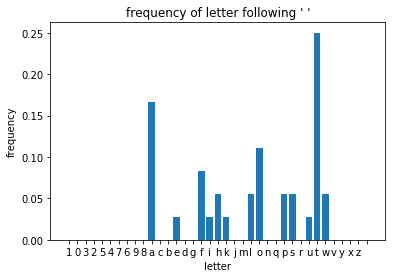

In [10]:
bigram_letter_analysis_graph(B_moby, H_moby, A_moby, ' ')

This is a bar graph is a slice of the bigram matrix down onto one dimension, where each bar represents the frequency of the letter following the slice. In this example, we use it to determine the most common letter following `' '`, the space character, which is thus the most common starting letter of a word.

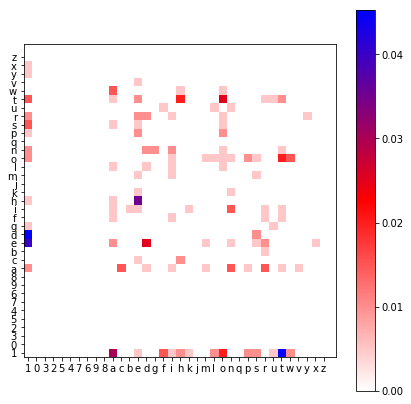

In [11]:
bigram_graph(A_moby, B_moby)

This is the full bigram matrix. Here, we can see that the most common bigrams are `'s '`, `' t'`, `'he'`, `'e '`. Note that the last three bigrams are the bigram decompositions of `the`, the most common word in the English language, and the first is just the fact that plurals typically end in `s`.

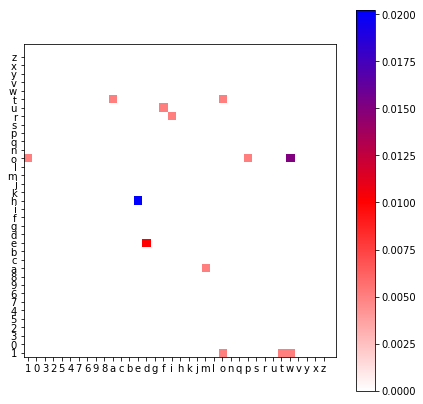

In [12]:
bigram_graph(A_moby, C_moby[H_moby['t']]) # projecting a trigram down onto the bigram by slicing it

Here is a slice of the trigram matrix at letter `t`. The graph represents every observed trigram which starts with the letter `t`. The y-axis is the middle letter, and the x-axis is the ending letter. As you can see, as expected, the highest trigram is `the`, which is expected for English.

### Initial Comparisons between Voynichese and English
Let's look at the visual differences between two identically sampled substrings of English.

three years housekeeping upon the wide ocean far from all grocers costermongers doctors bakers and bankers and though this also holds true of merchant vessels yet not by any means to the same extent as with whalemen for besides the great length of the whaling voyage the numerous articles peculiar to
 white charger large eyed small headed bluff chested and with the dignity of a thousand monarchs in his lofty overscorning carriage he was the elected xerxes of vast herds of wild horses whose pastures in those days were only fenced by the rocky mountains and the alleghanies at their flaming head he


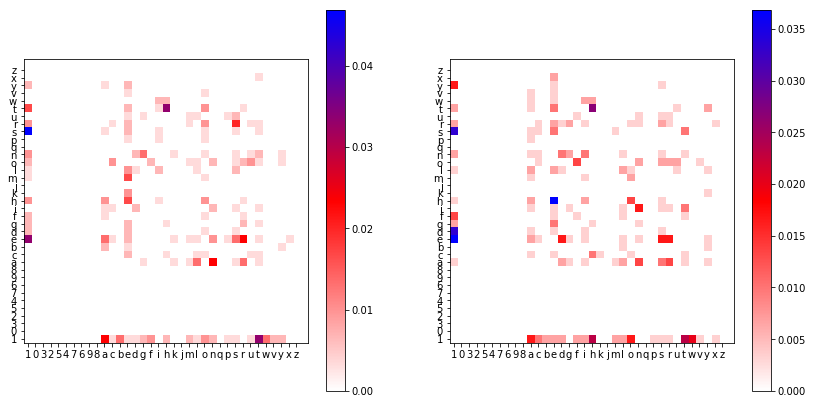

In [33]:
S_m1 = substring(T_moby, 300)
S_m2 = substring(T_moby, 300)

B_m1 = bigram(S_m1, H_moby)
B_m2 = bigram(S_m2, H_moby)

print S_m1
# bigram_graph(A_moby, B_m1)

print S_m2
# bigram_graph(A_moby, B_m2)

# A: alphabet (list), B: bigram
fig, ax = plt.subplots(figsize=(14,7))

plt.subplot(1,2,1)

cmap2 = mlp.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['white','red','blue'],
                                           256)
plt.xticks(range(len(A_moby)), A_moby)
plt.yticks(range(len(A_moby)), A_moby)


img2 = plt.imshow(B_m1,interpolation='nearest',
                    cmap = cmap2,
                    origin='lower'
                 )

plt.colorbar(img2,cmap=cmap2) # this is the color bar

plt.subplot(1,2,2)

cmap2 = mlp.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['white','red','blue'],
                                           256)
plt.xticks(range(len(A_moby)), A_moby)
plt.yticks(range(len(A_moby)), A_moby)


img2 = plt.imshow(B_m2,interpolation='nearest',
                    cmap = cmap2,
                    origin='lower'
                 )

plt.colorbar(img2,cmap=cmap2) # this is the color bar

plt.show()

Let's also determine a metric for the differences between two bigraphs: a sum of square differences (SSD).

In [29]:
B_diff = np.sum(np.square(B_m2 - B_m1))
print "SSD: " + str(B_diff)

SSD: 0.0066665920962852765


These metrics can also be applied to the trigram, which is an empirically superior Markov model for language identification.

In [30]:
C_m1 = trigram(S_m1, H_moby)
C_m2 = trigram(S_m2, H_moby)

C_diff = np.sum(np.square(C_m2 - C_m1))
print "SSD: " + str(C_diff)

SSD: 0.006283500743209765


# Discussion
What is the sensitivity of our test? Consider that in any sample substring of length $n$, the presence of a single $b$-length word will only lead to $b+2$ indicators in the bigram. This can easily be drowned out, since $\frac{b+2}{n}$ quickly approaches 0. For example, in English, the [average word length is 5.1 letters](https://arxiv.org/pdf/1208.6109.pdf), which means that in a substring of length $n=500$, a single Spanish word would only account for about 1% of the bigram. 

What is the rate of convergence to the mean? That is, how long must our substring be to get within $\alpha$% of the language's bigram?

Trigram models perform optimally. "For the bigraph model, optimal success (100%) was reached on text samples of 200 characters or more, whereas for the trigraph model, 100% success could be gained on samples of more than 175 characters." [link](https://www.researchgate.net/publication/246922625_Natural_language_identification_using_corpus-based_models) 

"Whereas, for a trigraph model, only 25-50% of the \[tri\]graphs need to be learned to achieve optimal recognition"[link](https://tidsskrift.dk/her/article/view/25083)

What if we boosted the words that appeared abberant? 

We need to bootstrap so that we can estimate variance of the bigrams.

Zipf's law: The frequency of a word is inversely proportional to its rank of usage. Derives from a Pareto distribution. The first place word is used about twice as much as the second, three times as much as the third, etc. 

Formally,
$$
P(W=w) \propto \frac{1}{(r_w+\beta)^{\alpha}},
$$
where $r$ is the rank of the usage of word $w$, and $\alpha$ and $\beta$ are shaping parameters.

Rehurek and Kolkus, 2009: 372/619


hapax legomenon

Can't use the CLT, because the bigrams are not identically distributed.

Do I scale by the whole sum (a doubly stochastic matrix) or by each row? 

$$
P(a_j \, | \, a_i) = \frac{ P(a_j \cap a_i) }{P(a_i)} = \frac{ \text{# of pairs $(a_i, a_j)$ or $(a_j, a_i)$} }{ \# \text{ of } a_i }
$$

# References
[statistical identification of language](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.48.1958&rep=rep1&type=pdf)
[natural language identification using corpus based methods](https://tidsskrift.dk/her/article/view/25083)
